In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score

import time
%matplotlib inline

## 1. Подготовка данных

Датасет взят с kaagle: https://www.kaggle.com/neisha/heart-disease-prediction-using-logistic-regression/data
<br>Где выбраны параметры, значительно влияющие на вероятность сердечных заболеваний 'TenYearCHD'(p-value < 5%):
- 'age'
- 'male'
- 'cigsPerDay'
- 'totChol'
- 'sysBP'
- 'glucose'

<br>В результате получена модель с использованием библиотеки sklearn.LogisticRegression с threshold=0.5:
- Точноть 0,88
- ROC AUC 0.735

glucose       3852
totChol       4190
cigsPerDay    4211
age           4240
male          4240
sysBP         4240
TenYearCHD    4240
dtype: int64

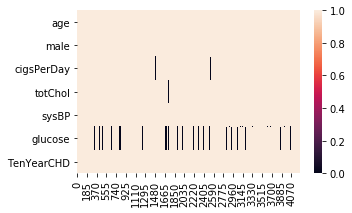

In [2]:
# Загрузка данных
raw = pd.read_csv('framingham.csv')[['age','male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]

# Визуализация заполненности данных
plt.figure(figsize=(5, 3))
sns.heatmap(raw.T.notnull())
raw.count().sort_values()

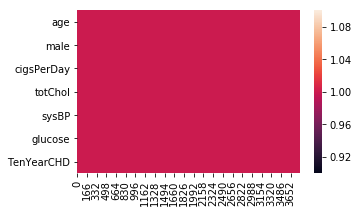

In [3]:
# Пустых данных немного - просот удалим строки, содержащие пустые записи
df = raw.dropna().reset_index(drop=True)
plt.figure(figsize=(5, 3))
sns.heatmap(df.T.notnull())

In [4]:
train = df.sample(frac=1).head(int(df.shape[0] * 0.8))
test = df[~df.index.isin(train.index)]

test_X = test.drop('TenYearCHD', axis=1).copy()
test_y = test['TenYearCHD'].copy()

print(train.shape, test.shape)

(3053, 7) (764, 7)


## 2. Логистическая регрессия
### 2.1
<br>это наиболее распространненный в индустрии машинного обучени метод классификации, который прост и при этом предоставляет хорошие результаты для линейно разделимых классов.

<br>Для простоты Y - бинарный (0 или 1) признак, зависящий от нескольких независимых объясняющих переменных:
$$P(Y=1) = f(x_{1},..x_{m}) $$

<br>При этом необходимо использовать такую функцию, которая преобразует комбинацию объясняющих признаков в величину от 0 до 1, чтобы соответствует диапазону вероятности:

$$P(Y_{i}=1) = \phi( \theta_{1}x_{1j},..\theta_{m}x_{mi} ) =
\phi \left( \sum_{j=1}^{m} ( \theta_{j} x_{ji} ) \right) =
\phi( x_{i}^T \theta ))$$

где $h_{j}$ - объясняющие переменные, $\theta_{j}$ - неизвестные параметры, в качестве $\phi$ используют **логистическую функцию**, где
$$z = x^T \theta = 
\Theta_{0} + \Theta_{1}x_{i} + \Theta_{2}^2x_{i} + \Theta_{m}^mx_{i} + \epsilon_{i}$$

$$\phi(z) = \frac{1}{1+exp^{-z}}$$

Эта функция гладкая, монотонно возрастает от $-\infty$ до $+\infty$
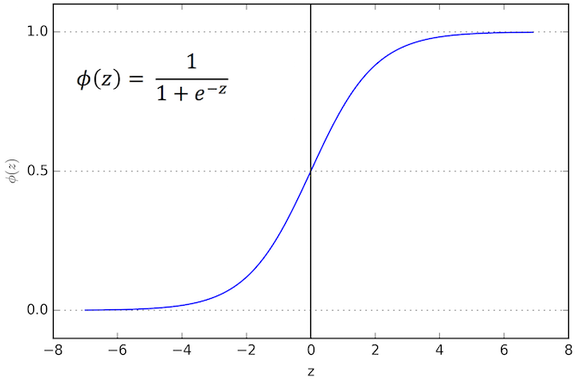

In [5]:
def initiation(df):
    X = df.drop('TenYearCHD', axis=1).copy()
    y = df['TenYearCHD'].copy()

    intercept = np.ones((X.shape[0], 1)) 
    X = np.concatenate((intercept, X), axis=1)
    theta = np.zeros(X.shape[1])
    return X, y, theta

def input_weights_combination(X, theta):
    z = np.dot(X, theta)
    return z

def sigmoid(z):
    result = 1 / (1 + np.exp(-z))
    return result

def prediction(X, theta, threshold):
    z = input_weights_combination(np.concatenate((np.ones((X.shape[0], 1)) , X), axis=1), theta)
    prediction = (sigmoid(z) >= threshold).astype(int)
    return prediction

In [6]:
num_iter = 100000

### 2.2 **Оценка параметров методом минимизации функции потерь _(logistic cost function)_**
<br>Альтернативный поиск параметров $\theta$ заключается в _минимизации_ функции потерь (***cost function***), используя алгоритм градиентного спуска (***gradient descent***).
<br>Функция потерь выглядит так:
$$J(\theta) = \frac{1}{n}\sum_{i=1}^{n} Cost(\phi(\theta_{i}, y_{i})=
\frac{1}{n}\sum_{i=1}^{n} [-Y_{i} * ln(\phi(z)) - (1-Y_{i}) * ln(  1 - \phi(z)) ] $$

где $z = h^T \theta$. Тогда потери для одного экземпляра:
$$J(\phi(z), y; \theta) = -y * ln(\phi(z)) - (1-y) * ln(  1 - \phi(z))$$
И тогда
- $J(\phi(z), y; \theta) = -ln(\phi(z))$  если $y=1$
- $J(\phi(z), y; \theta) = -ln(  1 - \phi(z))$  если $y=0$

In [7]:
def loss(z, y):
    loss = (-y * np.log(z) - (1 - y) * np.log(1 - z)).mean()
    return loss

Градиент - это среднее знчение производных функции потерь по каждому весу $\nabla J(\theta)$:

**a)** $ \frac{dJ}{d\theta} = \sum_{i=1} \frac{dJ}{d\phi_{i}}*\frac{d\phi_{i}}{dz_{i}}*\frac{dz_{i}}{d\theta}$

**b)** $\frac{dJ}{d\phi_{i}} =
\frac{d}{d\phi_{i}} \left( \frac{1}{n}\sum_{i=1} [-y_{i} * ln(\phi_{i}(z)) - (1-y_{i}) * ln(  1 - \phi_{i}(z)) ] \right) = 
\frac{1}{n}\sum_{i=1} \left( -\frac{y_{i}}{\phi_{i}(z)} + \frac{1-y_{i}}{1-\phi_{i}(z)} \right)$

**c)** $\frac{d\phi_{i}(z)}{dz_{i}} =
\frac{d}{dz_{i}} \left(\frac{1}{1+exp(-z_{i})} \right) =
\frac{d(1+exp(-z_{i}))^{-1})}{dz_{i}} =
(1+exp(-z_{i}))^{-2}*(-exp(-z_{i})) =
\frac{exp(-z_{i})}{(1+exp(-z_{i}))^2} =
\frac{1}{1+exp(-z_{i})}*\frac{exp(-z_{i})}{1+exp(-z_{i})} =
\frac{1}{1+exp(-z_{i})}*\frac{exp(-z_{i})+1-1}{1+exp(-z_{i})} =
\frac{1}{1+exp(-z_{i})}* \left( 1 - \frac{1}{1+exp(-z_{i})} \right) =
\phi_{i}(z)(1-\phi_{i}(z))$

**d)** $\frac{dz_{i}}{d\theta} =
\frac{d}{d\theta} \left( x_{i}\theta \right) =
x_{i}$

**a, b, c, d =>** $\frac{dJ}{d\theta} = \frac{1}{n}\sum_{i=1} \left( -\left(\frac{y_{i}}{\phi_{i}(z)} - \frac{1-y_{i}}{1-\phi_{i}(z)} \right) \right) * 
\phi_{i}(z)(1-\phi(z)) *
x_{i} = 
\frac{1}{n}\sum_{i=1} \left( [-y_{i}(1-\phi_{i}(z)) + (1-y_{i})\phi_{i}(z)]*x_{i} \right) =
\frac{1}{n}\sum_{i=1} \left( -(y_{i} - \phi_{i}(z))*x_{i} \right) =$ $\frac{1}{n}\sum_{i=1} \left( (\phi_{i}(z) - y_{i})*x_{i} \right)$

$$\nabla J(\theta) = \frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{n}\sum_{i=1} \left( (\phi_{i}(z) - y_{i})*x_{i} \right)$$

In [8]:
def gradient_descent(X, y, result):
    gradient = np.dot(X.T, (result - y)) / y.shape[0]
    return gradient

def update_weight_loss(weights, learning_rate, gradient):
    updated_weights = weights - learning_rate * gradient
    return updated_weights

In [9]:
start_time = time.time()

X, y, theta = initiation(df)

for i in range(num_iter):
    z = input_weights_combination(X, theta)
    result = sigmoid(z)
    gradient = gradient_descent(X, y, result)
    theta = update_weight_loss(theta, 0.1, gradient)
    
time_cost_func = time.time() - start_time
print('Время на обуечние: {} секунд'.format(str(time_cost_func)))
print('Количество итераций при learning_rate=0,1 составляет {}'.format(num_iter))

C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Время на обуечние: 43.61556625366211 секунд
Количество итераций при learning_rate=0,1 составляет 100000


In [10]:
preds_cost_func = prediction(test_X, theta, 0.5)
accuracy_cost_func = (preds_cost_func == test_y).mean()
print('Точность метода минимизации функции потерь: {}'.format(str(accuracy_cost_func)))

Точность метода минимизации функции потерь: 0.8350785340314136


C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


### 2.3 **Оценка параметров методом максимизации правдоподобия _(likelihood)_**
<br>Чтобы оценить параметры $\theta$ пользуются методом максимального правдоподобия. Идея ММП основана на гипотезе, что полученные наблюдения не содержат аномалий. И соответственно вероятность получить такие типичные наблюдения должна быть достаточно большой. И мы подбираем коэффициенты (параметры $\theta$) такие, чтобы вероятность получить именно те значения, которые мы получили (наблюдения) была бы максимально возможной. Эот и есть _физический смысл_ функции правдоподобия $L(Y, \theta)$ (_likelihood_), которую максимизируют (ищут точку максимума):
$$L(Y, \theta) = \prod_{i=1}^{n} \left(  \phi(z) \right)^{Y_{i}} * \left(  1 - \phi(z) \right)^{1 - Y_{i}}$$
<br>$n$ - количество наблюдений,
<br>$\phi(h^T\theta)$ - вероятность получить $Y_{i}=1$,
<br>$\left(  1 - \phi( z ) \right)$ - вероятность получить $Y_{i}=0$.
<br>Чтобы облегчить нахождение максимума приводят функцию правдоподобия к логарифму:
$$lnL(Y, \theta) = \sum_{i=1}^{n} [ln(\phi(z))^{Y_{i}} + ln( 1 - \phi(z))^{1-Y_{i}} ] $$

$$lnL(Y, \theta) = \sum_{i=1}^{n} [Y_{i} * ln(\phi(z)) + (1-Y_{i}) * ln(  1 - \phi(z)) ] $$

$$\overset{-}{\theta} = \underset{\theta}{argmax}(lnL(Y, \theta)))$$

Далее в качестве алгоритма оптимизации применяют градиентное восхождение (_gradient ascent_) для наождения максимума функции правдоподобия.

In [11]:
def log_likelihood(z, y):
    ll = np.sum(y * z - np.log(1 + np.exp(z)))
    return ll

def gradient_ascent(X, y, result):
    gradient = np.dot(X.T, y - result)
    return gradient

def update_weight_mle(weights, learning_rate, gradient):
    updated_weights = weights + learning_rate * gradient
    return updated_weights

In [12]:
start_time = time.time()

X, y, theta = initiation(train)

for i in range(num_iter):
    z = input_weights_combination(X, theta)
    result = sigmoid(z)
    gradient = gradient_ascent(X, y, result)
    theta = update_weight_mle(theta, 0.1, gradient)
    
time_likelihood = time.time() - start_time
print('Время на обуечние: {} секунд'.format(str(time_likelihood)))
print('Количество итераций при learning_rate=0,1 составляет {}'.format(num_iter))

C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


Время на обуечние: 42.21549844741821 секунд
Количество итераций при learning_rate=0,1 составляет 100000


In [13]:
preds_likelihood = prediction(test_X, theta, 0.5)
accuracy_likelihood = (preds_likelihood == test_y).mean()
print('Точность метода максимального правдоподобия: {}'.format(str(accuracy_likelihood)))

Точность метода максимального правдоподобия: 0.8350785340314136


C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


### 2.4 Оценка параметров методами библиотеки sklearn.LogisticRegression

In [14]:
start_time = time.time()

X = test.drop('TenYearCHD', axis=1).copy()
y = test['TenYearCHD'].copy()

logreg = LogisticRegression()
logreg.fit(X, y)


time_sklearn = time.time() - start_time
print('Время на обуечние: {} секунд'.format(str(time_sklearn)))
preds_sklearn = logreg.predict(X)

accuracy_sklearn = accuracy_score(test_y, preds_sklearn)
print('Точность библиотеки skleran: {}'.format(str(accuracy_sklearn)))


Время на обуечние: 0.007937192916870117 секунд
Точность библиотеки skleran: 0.8350785340314136


C:\Users\stepanovaev9\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
pd.DataFrame([[time_cost_func, accuracy_cost_func],
              [time_likelihood, accuracy_likelihood],
              [time_sklearn, accuracy_sklearn]], 
             columns = ['Time', 'Accuracy'],
             index=['Метод минимизации функции потерь', 'Метод максимального правдоподобия', 'Sklearn'])

,Time,Accuracy
Метод минимизации функции потерь,43.615566,0.835079
Метод максимального правдоподобия,42.215498,0.835079
Sklearn,0.007937,0.835079
